In [898]:
import pandas as pd

csv = pd.read_csv("cleaned_dataset.csv")

add filters

In [ ]:
import numpy as np


get datas

model of Number of scheduled trains x Number of trains delayed at arrival and tx of performance R2

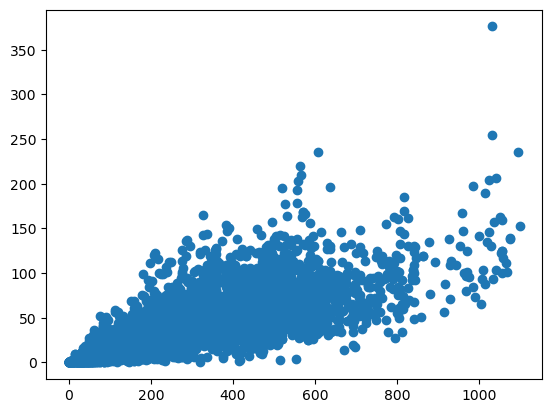

In [900]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score

newcsv = csv.dropna(subset = "Number of trains delayed at arrival")
newcsv = newcsv.dropna(subset = "Number of scheduled trains")
x = newcsv["Number of scheduled trains"]
y = newcsv["Number of trains delayed at arrival"]
train_x = x[:(int)(len(newcsv) * (80 / 100))]
train_y = y[:(int)(len(newcsv) * (80 / 100))]
test_x = x[(int)(len(newcsv) * (80 / 100)):]
test_y = y[(int)(len(newcsv) * (80 / 100)):]
scheduled_delayedarr = np.poly1d(np.polyfit(train_x, train_y, 3))
r2_scheduled_delayedarr = r2_score(test_y, scheduled_delayedarr(test_x))
nbr = scheduled_delayedarr(100)
plt.scatter(x, y)
plt.show()

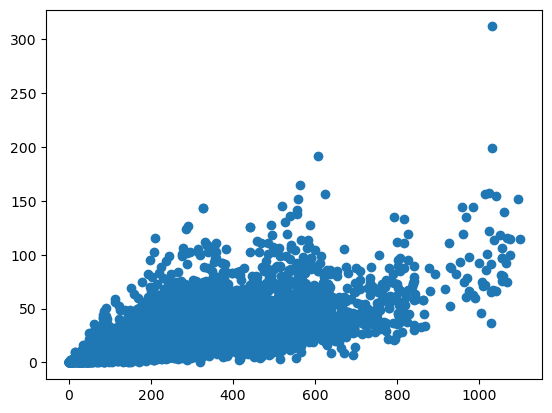

11.578413734187318 0.4902470613435118


In [901]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import r2_score

newcsv = csv.dropna(subset = "Number of trains delayed > 15min")
newcsv = newcsv.dropna(subset = "Number of scheduled trains")
x = newcsv["Number of scheduled trains"]
y = newcsv["Number of trains delayed > 15min"]
train_x = x[:(int)(len(newcsv) * (80 / 100))]
train_y = y[:(int)(len(newcsv) * (80 / 100))]
test_x = x[(int)(len(newcsv) * (80 / 100)):]
test_y = y[(int)(len(newcsv) * (80 / 100)):]
scheduled_delayedarr = np.poly1d(np.polyfit(train_x, train_y, 3))
r2_scheduled_delayedarr = r2_score(test_y, scheduled_delayedarr(test_x))
nbr = scheduled_delayedarr(100)
plt.scatter(x, y)
plt.show()
print(nbr, r2_scheduled_delayedarr)


In [902]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class StationData:
    def __init__(self, csv, date):
        data = {}
        newcsv = csv.dropna(subset = "Date")
        newcsv = newcsv[(newcsv["Date"] >= date[0]) & (newcsv["Date"] <= date[1])]
        print(newcsv)
        for i in range(len(newcsv)):
            station = newcsv.iloc[i]["Departure station"]
            scheduled = newcsv.iloc[i]["Number of scheduled trains"]
            cancelled = newcsv.iloc[i]["Number of cancelled trains"]
            late = newcsv.iloc[i]["Number of trains delayed at departure"]

            if pd.notna(station) and pd.notna(scheduled) and pd.notna(cancelled) and pd.notna(late):
                if station not in data:
                    data[station] = [0, 0, 0]
                data[station][0] += scheduled
                data[station][1] += cancelled
                data[station][2] += late

        self.df = pd.DataFrame.from_dict(
            data, orient='index', columns=['Scheduled', 'Cancelled', 'Late']
        ).reset_index()
        self.df = self.df.rename(columns={'index': 'Departure station'})

    def station_scheduled_late(self, station_list):
        df = self.df
        df.loc[~df["Departure station"].isin(station_list), "Departure station"] = np.nan
        df = df.dropna(subset = "Departure station")
        pos = np.arange(len(df["Departure station"]))
        width = 0.5
        plt.barh(pos + width / 3, df["Late"], width / 3, color='lightsteelblue', label='Late')
        plt.barh(pos, df["Scheduled"], width / 3, color='IndianRed', label='Scheduled')
        plt.barh(pos - width / 3, df["Cancelled"], width / 3, color='Blue', label='Cancelled')
        plt.yticks(pos, df["Departure station"])
        plt.xlabel("Number of Trains", fontsize=14)
        plt.title("Scheduled, Cancelled, and Late Trains per Station", fontsize=15)
        plt.legend()
        plt.tight_layout()
        plt.show()


            Date        Service   Departure station       Arrival station  \
2898  2020-01-01  INTERNATIONAL           BARCELONA            PARIS LYON   
2899  2020-01-01  INTERNATIONAL           FRANCFORT             PARIS EST   
2900  2020-01-01  INTERNATIONAL              GENEVE            PARIS LYON   
2901  2020-01-01  INTERNATIONAL            LAUSANNE            PARIS LYON   
2902  2020-01-01  INTERNATIONAL              MADRID  MARSEILLE ST CHARLES   
...          ...            ...                 ...                   ...   
5726  2021-12-01       NATIONAL              TOULON            PARIS LYON   
5727  2021-12-01       NATIONAL           TOURCOING      BORDEAUX ST JEAN   
5728  2021-12-01       NATIONAL               TOURS    PARIS MONTPARNASSE   
5729  2021-12-01       NATIONAL  VALENCE ALIXAN TGV            PARIS LYON   
5730  2021-12-01       NATIONAL              VANNES    PARIS MONTPARNASSE   

      Average journey time  Number of scheduled trains  \
2898             

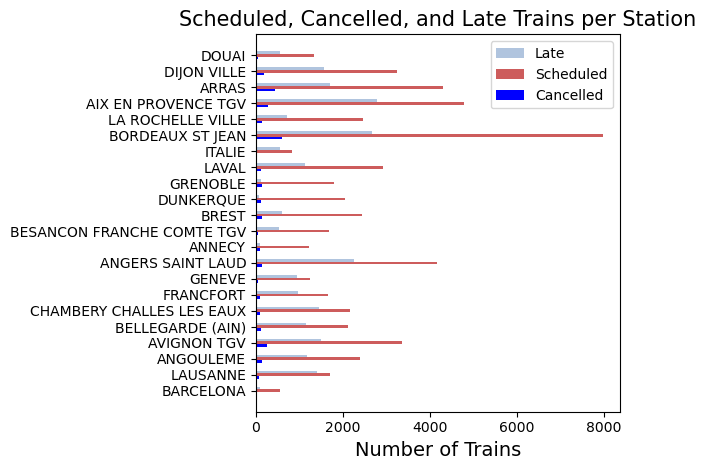

In [ ]:
stdata = StationData(csv, date)
stdata.station_scheduled_late(station_list)

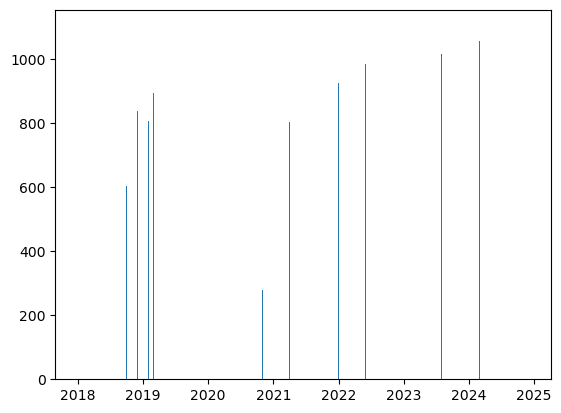

In [904]:
newcsv = csv.dropna(subset="Date")
newcsv = newcsv.dropna(subset="Number of scheduled trains")
newcsv["Date"] = pd.to_datetime(newcsv["Date"])
newcsv["Date"] = newcsv["Date"].convert_dtypes(float)
x = newcsv["Date"]
y = newcsv["Number of scheduled trains"]
plt.bar(x, y)
plt.show()